In [1]:
import pyxdf
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfilt, sosfiltfilt
from enum import IntEnum
import mne

In [2]:
DATA_PATH = "data/muse_sample.xdf"

class MuseChannel(IntEnum):
    TP9 = 0
    AF7 = 1
    AF8 = 2
    TP10 = 3

In [3]:
def regularize_stream(timestamps, data, target_fs):
    start_time = timestamps[0]
    end_time = timestamps[-1]
    duration = end_time - start_time
    expected_samples = int(duration * target_fs)
    perfect_timestamps = np.linspace(start_time, end_time, expected_samples)
def load_experiment_data(xdf_path):
    print(f"Loading {xdf_path}")
    streams, header = pyxdf.load_xdf(xdf_path, synchronize_clocks=True)
    dataset = {
        "beam": None,
        "polar_ecg": None,
        "muse_eeg": None,
        "muse_optics": None,
        "muse_accgyro": None,
        "omnibuds_ppg": None,
        "omnibuds_acc": None,
        "omnibuds_gyro": None,
        "omnibuds_mag": None,
        "band_gsr": None,
        "band_hr": None,
        "user_ratings": None,
        "video_timestamp": None
    }
    
    for stream in streams:
        stream_name = stream['info']['name'][0]
        stream_type = stream['info']['type'][0]
        
        data = stream['time_series']
        timestamps = stream['time_stamps']

        print(timestamps)

        if "Muse" in stream_name:
            if "EEG" in stream_name or "EEG" in stream_type:
                dataset["muse_eeg"] = (timestamps, data[:, :4]) # :4 removes the last 4 channels, which are floating auxilliaries
                print(f"Found Muse EEG ({len(data)} samples)")
            elif "OPTICS" in stream_name or "PPG" in stream_type:
                dataset["muse_optics"] = (timestamps, data)
                print(f"Found Muse Optics ({len(data)} samples)")
            elif "ACCGYRO" in stream_name or "ACCGYRO" in stream_type:
                dataset["muse_accgyro"] = (timestamps, data)
                print(f"Found Muse IMU ({len(data)} samples)")
    
    return dataset

def convert_eeg_to_mne(eeg_data, fs=256):
    info = mne.create_info(ch_names=['TP9', 'AF7', 'AF8', 'TP10'], sfreq=fs, ch_types=['eeg', 'eeg', 'eeg', 'eeg'])
    raw = mne.io.RawArray(eeg_data.T * 1e-6, info)
    montage = mne.channels.make_standard_montage('standard_1020') # For visualization
    raw.set_montage(montage)
    return raw 


Creating RawArray with float64 data, n_channels=4, n_times=7584
    Range : 0 ... 7583 =      0.000 ...    29.621 secs
Ready.


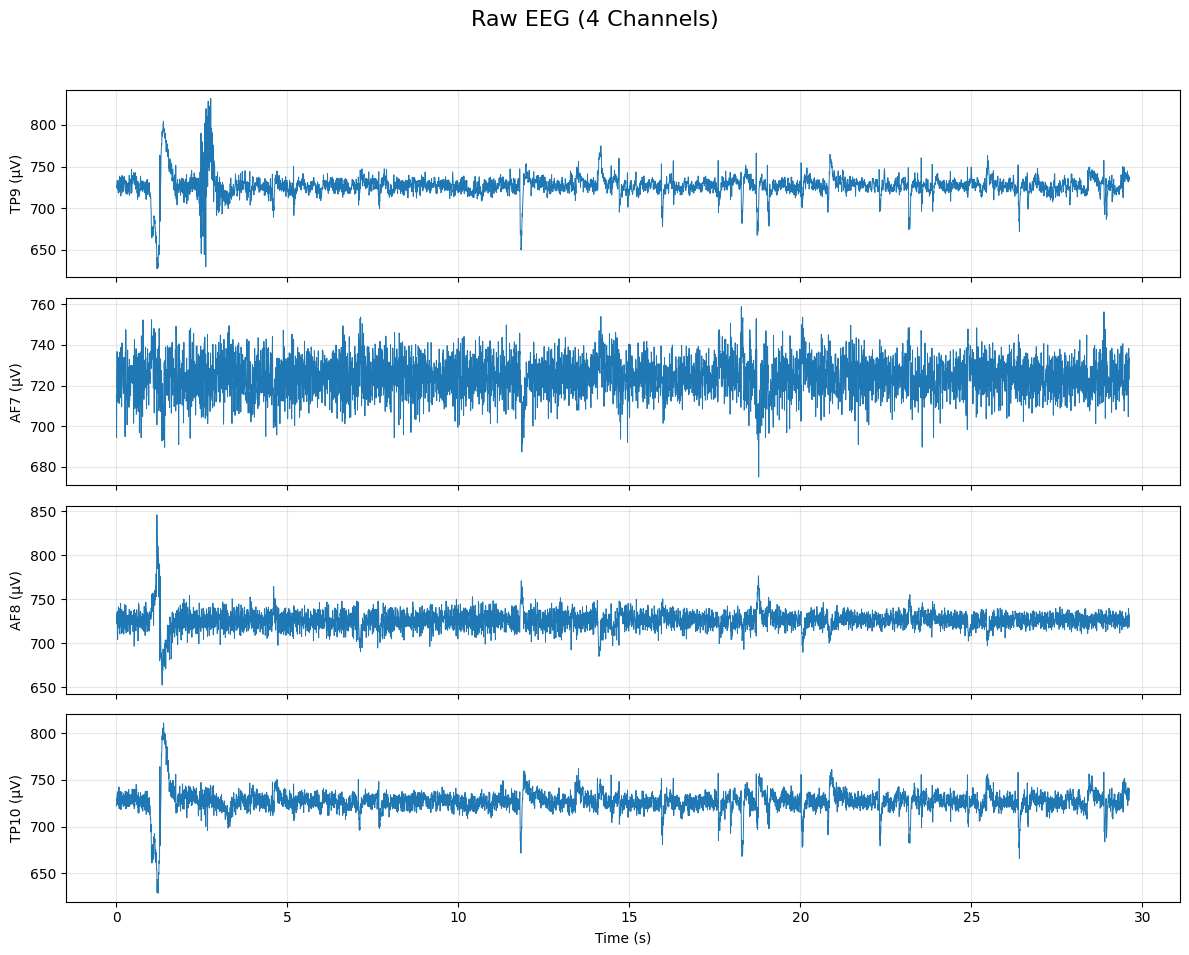

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



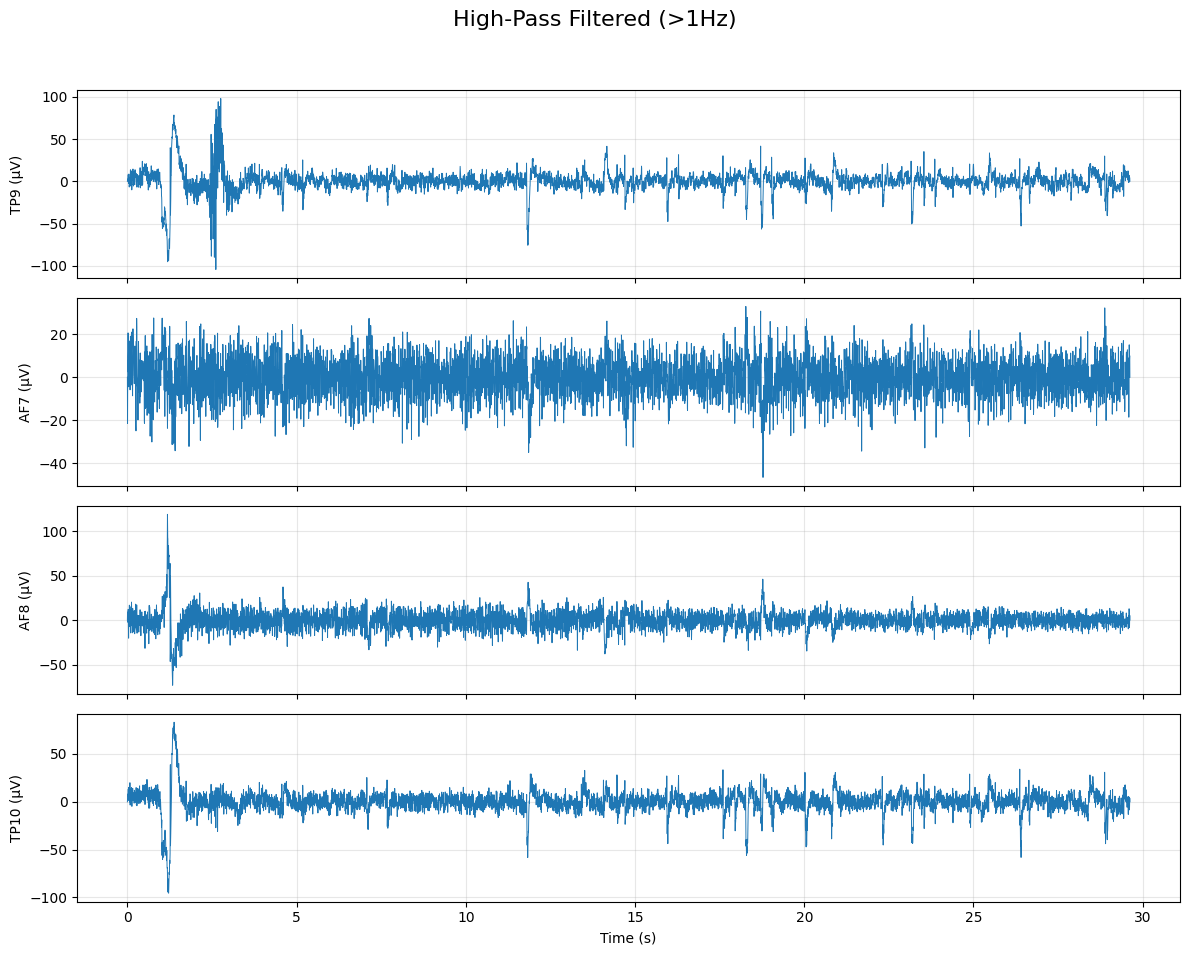

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 54 - 66 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 54.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 54.25 Hz)
- Upper passband edge: 65.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 65.75 Hz)
- Filter length: 1691 samples (6.605 s)



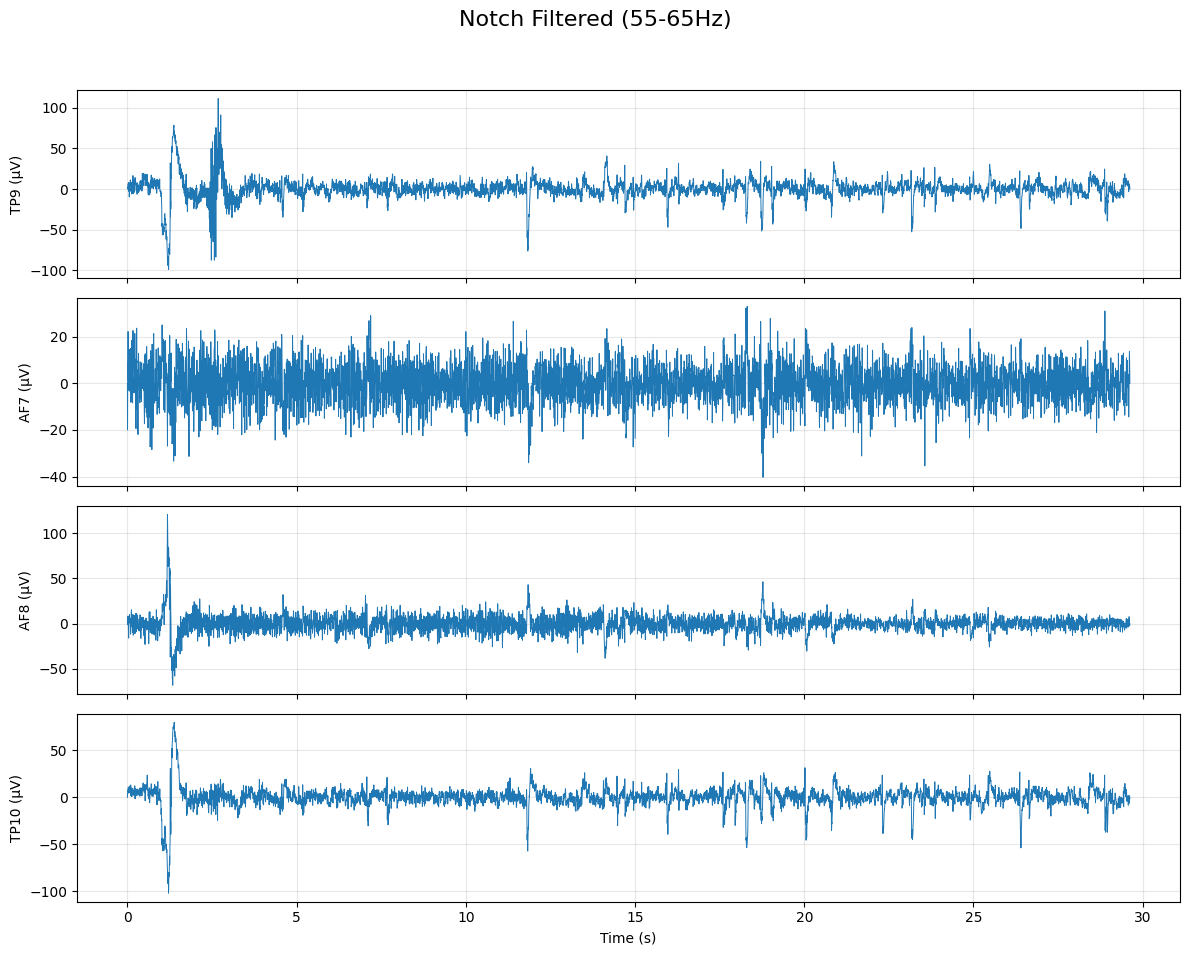

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.0s.
Using EOG channels: AF7, AF8
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz 

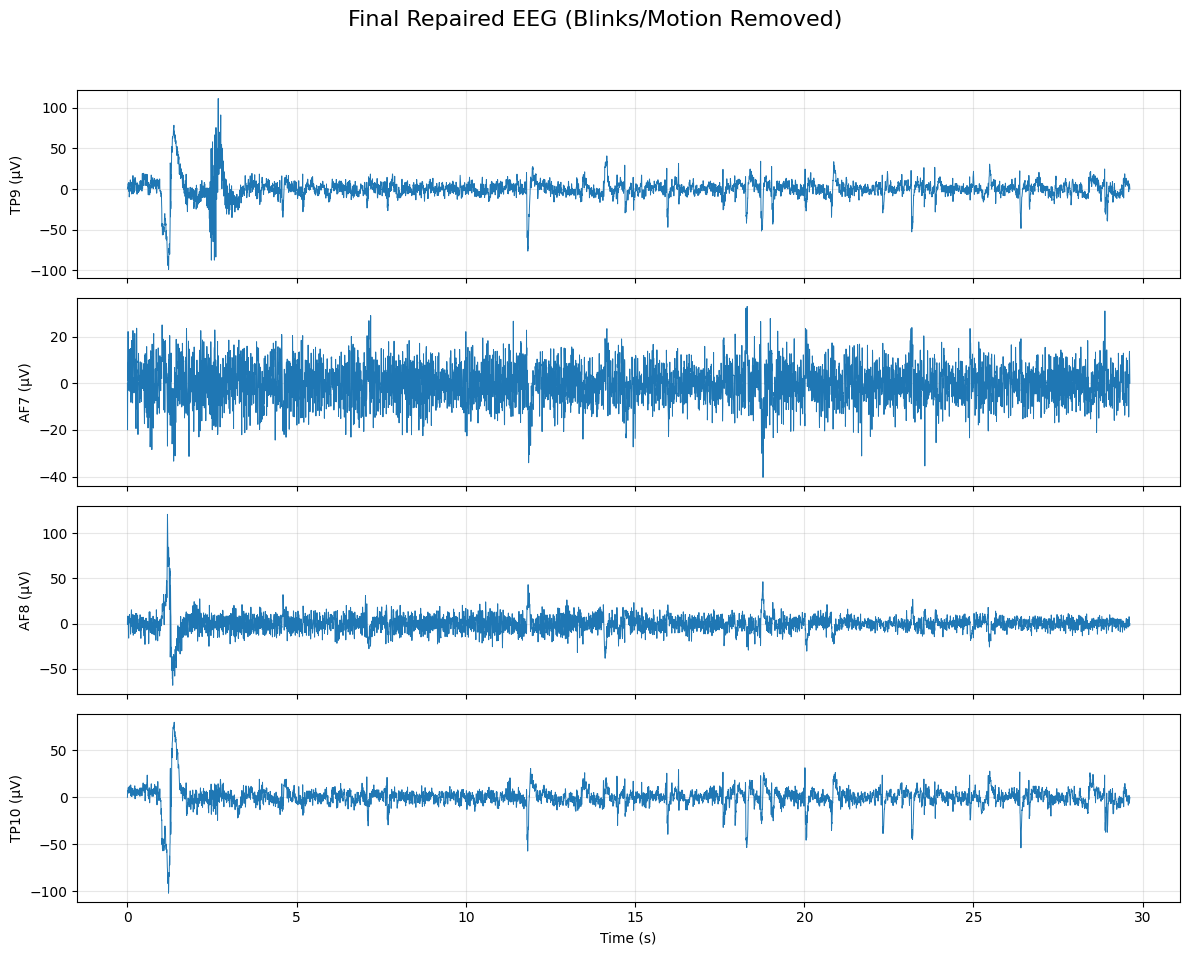

In [ ]:
import matplotlib.pyplot as plt

def plot_four_channels(mne_raw, title):
    """Utility to plot each Muse channel in its own subplot."""
    data = mne_raw.get_data()  # Shape: (channels, samples)
    times = mne_raw.times
    ch_names = mne_raw.ch_names
     
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes):
        ax.plot(times, data[i] * 1e6, linewidth=0.7) # Convert back to microvolts
        ax.set_ylabel(f"{ch_names[i]} (μV)")
        ax.grid(True, alpha=0.3)
    
    ax.set_xlabel("Time (s)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution Pipeline ---

# 1. Raw Data
raw = convert_eeg_to_mne(eeg_values, fs=fs)
plot_four_channels(raw, "Raw EEG (4 Channels)")

# 2. High-Pass Filter (1Hz)
raw_highpass = raw.copy().filter(l_freq=1.0, h_freq=None)
plot_four_channels(raw_highpass, "High-Pass Filtered (>1Hz)")

# 3. Notch Filter (55-65Hz)
# We apply the notch specifically across your requested range
# Use a center frequency of 60Hz and a wider notch_widths to cover the 55-65 range
# notch_widths=10 means 60 +/- 5Hz
raw_notch = raw.copy().notch_filter(freqs=60.0, notch_widths=10.0)
plot_four_channels(raw_notch, "Notch Filtered (55-65Hz)")

# 4. ICA Repair
# Muse only has 4 channels, so we can extract a maximum of 4 components
ica = mne.preprocessing.ICA(n_components=4, random_state=97, max_iter=800)
ica.fit(raw_notch)

# Detect artifacts based on AF7/AF8 (frontal channels)
blink_indices, scores = ica.find_bads_eog(raw_notch, ch_name=['AF7', 'AF8'])
ica.exclude = blink_indices

raw_repaired = raw_notch.copy()
ica.apply(raw_repaired)
plot_four_channels(raw_repaired, "Final Repaired EEG (Blinks/Motion Removed)")